In [17]:
import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils.class_weight import compute_sample_weight

shap.initjs()

In [5]:
# Data load
data = pd.read_csv("./CaliforniaFireDamage2013_2020_parsed.csv")
data.head(10)

# Encode damage amounts as binary classes
data["Damage"].replace({'No Damage': 0, 
                        'Affected (1-9%)': 0, 
                        'Minor (10-25%)': 1,
                        'Major (26-50%)': 1,
                        'Destroyed (>50%)': 1}, inplace=True)

# Data is unbalanced at ~3:1 ratio
data["Damage"].value_counts()

1    22444
0     7106
Name: Damage, dtype: int64

In [6]:
# One hot encode remaining categorical variables
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_encode = ['Structure_Type', 
                      'Structure_Category', 
                      'Roof_Construction',
                      'Exterior_Siding',
                      'Window_Pane',
                      'Deck_or_Porch_On_Grade',
                      'Deck_or_Porch_Elevated',
                      'Patio_Cover_or_Carport_Attached',
                      'Fence_Attached',
                      'Wildfire_Score',
                      'Vegetation',
                      'Drought_Frequency',
                      'Aspect',
                      'Slope_Risk']

for feature in features_to_encode:
    data = encode_and_bind(data, feature)

In [7]:
# Create training and test dataset
y = data["Damage"]
X = data.drop(columns=['Damage', 
                       'Site_Address', 
                       'Latitude', 
                       'Longitude'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7, shuffle=True)

In [8]:
# Model fit
xgbm = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric="logloss")
xgbm = xgbm.fit(X_train, y_train, sample_weight=compute_sample_weight("balanced", y_train))

In [9]:
# Cross validation
kfold = StratifiedKFold(n_splits=10)
results = cross_val_score(xgbm, X_train, y_train, cv=kfold)

Mean accuracy across the folds is 88.02%


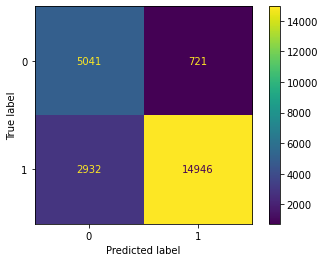

In [10]:
# Mean accuracy from CV and contingency table for training data
print(f"Mean accuracy across the folds is {np.round(np.mean(results) * 100, 2)}%")

# Confusion matrix
plot_confusion_matrix(xgbm, X_train, y_train)  
plt.show()  

In [11]:
# Prediction on 20% of data
y_pred = xgbm.predict(X_test)
cr = classification_report(y_test, y_pred, output_dict=True)
print(f"Model accuracy on test data is {np.round(cr['accuracy'] * 100, 2)}%")
print(f"Model weighted avg precision on test data is {np.round(cr['weighted avg']['precision'], 2)}")
print(f"Model weighted avg recall on test data is {np.round(cr['weighted avg']['recall'], 2)}")

# Feature importances
# for i in range(len(xgbm.feature_importances_)):
#     print(X_train.columns[i])

Model accuracy on test data is 84.31%
Model weighted avg precision on test data is 0.87
Model weighted avg recall on test data is 0.84


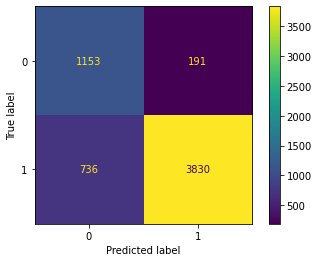

In [12]:
plot_confusion_matrix(xgbm, X_test, y_test)  
plt.show()  

In [13]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(xgbm)
shap_values = explainer.shap_values(X_test)

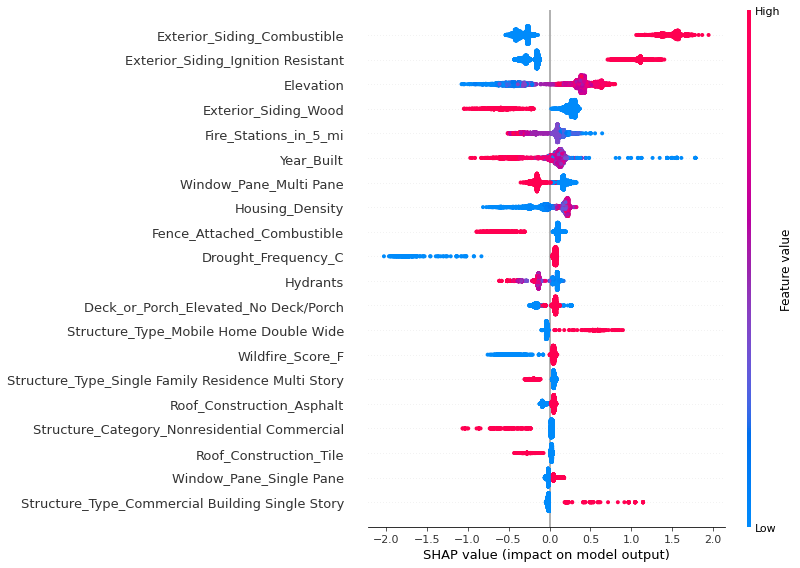

In [14]:
# Summary plot
shap.summary_plot(shap_values, X_test)

In [34]:
# Cherry pick a house for pretty display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

shap.force_plot(explainer.expected_value, shap_values[40,:], X_test.iloc[40,:])